# Exploring the ConfigurableRecommendationNet with New Users and Movies

## Introduction

In this notebook, we aim to extend the capabilities of the **ConfigurableRecommendationNet** by testing its adaptability to new users and new movies. Building on the advancements from the previous notebook, where we optimized and regularized the recommendation system, this experiment focuses on evaluating the system's ability to generalize and integrate novel data points effectively.

### Objectives
1. **Profile Creation**:
   - Generate new user profiles with unique preferences and attributes.
   - Construct new movie profiles with distinct characteristics and features.

2. **Testing Scenarios**:
   - Evaluate the model's predictions for **new users interacting with existing movies**.
   - Assess the system's response to **existing users interacting with new movies**.
   - Analyze the performance for **new users interacting with new movies**.

### Research Questions
- Can the ConfigurableRecommendationNet generate meaningful recommendations for unseen users and movies?
- How effectively does the model adapt to profiles that were not part of the training set?
- What insights can we gain about the feature embeddings generated for new users and movies?

### Approach
1. **Data Augmentation**:
   - Leverage the model's existing pipeline to create embeddings for new entities.
   - Introduce diverse data for users and movies to ensure comprehensive testing.

2. **Evaluation Metrics**:
   - Compare recommendation quality across different testing scenarios.
   - Analyze the similarity and differences in recommendations for new vs. existing entities.

3. **Insights and Interpretation**:
   - Investigate whether the model's architecture, regularization, and optimization techniques contribute to its ability to generalize.
   - Highlight areas where the model performs well and identify potential gaps for future improvements.

### Why This Experiment Matters
Real-world recommendation systems often encounter scenarios with cold-start problems—where new users or items lack sufficient historical data. This notebook aims to simulate such challenges and evaluate how effectively the **ConfigurableRecommendationNet** addresses them, setting the stage for robust, real-world applications.

Let’s dive in and uncover how well our recommendation system performs in the presence of novel entities!


# Objectives of the Notebook

In this notebook, we aim to evaluate the performance of the **ConfigurableRecommendationNet** for new user profiles and their associated predictions. Since no explicit ground truth exists for these new users, we will adopt the following evaluation methods:

## 1. **Precision@K for Genre Alignment**
- **Objective**: Evaluate how well the recommended movies align with the new users' favorite genres.
- **Approach**:
  - For each new user, predict the top-K recommended movies.
  - Compare the genres of these movies with the user's favorite genres.
  - Calculate **Precision@K** to measure the proportion of recommendations that match the user's genre preferences.
- **Metric**:
  $$
  \text{Precision@K} = \frac{\text{Number of recommended movies whose genres match the user's favorite genres}}{K}
  $$

## 2. **Embedding Quality Assessment**
- **Objective**: Ensure that the embeddings of new users and movies integrate well with the existing learned representations.
- **Approach**:
  - Use **clustering algorithms** (e.g., k-means) or visualization tools (e.g., t-SNE, UMAP) to inspect the new embeddings.
  - For new users:
    - Verify if their embeddings cluster near existing users with similar favorite genres.
  - For new movies:
    - Check if embeddings align with movies of similar genres.
- **Insights**: This will help validate whether the recommendation system is learning meaningful representations for unseen profiles.

## 3. **Content Similarity Validation**
- **Objective**: Measure if the recommendations are semantically consistent with the user's profile, beyond just genre alignment.
- **Approach**:
  - Calculate the **cosine similarity** between the user profile vector and the profile vectors of the recommended movies.
  - Analyze whether the recommendations with higher similarity scores are consistently ranked higher.
- **Insights**: This ensures that the recommendations are well-aligned with the overall profile features.

By combining these evaluation strategies, we aim to comprehensively analyze the system's performance for unseen user profiles, focusing on both the quality of recommendations and the meaningfulness of generated embeddings.


# Creating synthetic new user data

In [7]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import pandas as pd
import torch
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer
import numpy as np
from codebase.v13.data import UserProfileCreator, MovieProfileCreator
import os

# ----------------------------------------------------------------
# Configuration / Constants
# ----------------------------------------------------------------

MOVIES_ENRICHED_PATH = 'data/ml-10k-users/movies_enriched_tags.csv'
USER_ENRICHED_PATH = 'data/ml-10k-users/users_enriched_tags.csv'
USER_EMBEDDINGS_PATH = 'data/ml-10k-users/user_profiles.npy'
MOVIE_EMBEDDINGS_PATH = 'data/ml-10k-users/movie_profiles.npy'
BATCH_SIZE = 512
MODEL_NAME = 'all-mpnet-base-v2'

os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np
import random
import csv  # To ensure proper CSV formatting

# Load the existing users file to extract available genres and tags
file_path = USER_ENRICHED_PATH  # Update with your actual file path
users_data = pd.read_csv(file_path)

# Extract unique genres and tags
available_genres = list(set(",".join(users_data['favorite_genres'].dropna().unique()).split(',')))
available_tags = list(set(",".join(users_data['tags_user'].dropna().unique()).split(',')))

# Define the number of new users to generate
num_new_users = 100

# Function to generate random user data
def generate_user_data(user_id):
    age = np.random.randint(18, 65)  # Age range: 18-65
    sex = random.choice(['M', 'F'])  # Male or Female
    num_reviews = np.random.randint(0, 1000)  # Number of reviews
    avg_rating = np.random.uniform(1, 5)  # Average rating: 1-5
    spending_category = random.choice(['low', 'medium', 'high'])  # Spending category
    favorite_genres = ",".join(random.sample(available_genres, np.random.randint(1, 4)))  # 1-3 genres
    tags_user = (
        ",".join(random.sample(available_tags, np.random.randint(1, 4)))
        if np.random.rand() > 0.5
        else ""  # Tags for some users
    )
    return [user_id, age, sex, num_reviews, avg_rating, spending_category, favorite_genres, tags_user]

# Generate the new user data
new_users_data = [generate_user_data(user_id) for user_id in range(1, num_new_users + 1)]

# Create a DataFrame for the new users
new_users_df = pd.DataFrame(
    new_users_data,
    columns=['userId', 'age', 'sex', 'num_reviews', 'avg_rating', 'spending_category', 'favorite_genres', 'tags_user']
)

# Save the new users to a CSV file with proper escaping
new_users_file = 'data/ml-10k-users/new_users_enriched_tags.csv'  # Update with your desired file name
new_users_df.to_csv(
    new_users_file, 
    index=False, 
    quoting=csv.QUOTE_ALL,  # Ensure all fields are properly escaped
    quotechar='"',  # Use double quotes for escaping
    escapechar='\\'  # Use backslash for escaping special characters
)

print(f"New user data saved to {new_users_file}")


New user data saved to data/ml-10k-users/new_users_enriched_tags.csv


Let's now use those new users to create user profiles.

In [5]:
new_users = pd.read_csv('data/ml-10k-users/new_users_enriched_tags.csv')

text_model = SentenceTransformer(MODEL_NAME).to(device)

# Combine favorite genres from users and genres from movies
genre_vocab = sorted(
    set(
        [
            genre.strip() 
            for genre in ','.join(new_users['favorite_genres'].dropna()).split(',')
        ]        
    )
)

user_profile_creator = UserProfileCreator(text_model, genre_vocab=genre_vocab)
user_profiles = user_profile_creator.create_profiles(new_users)

Let's visualise a user profile:

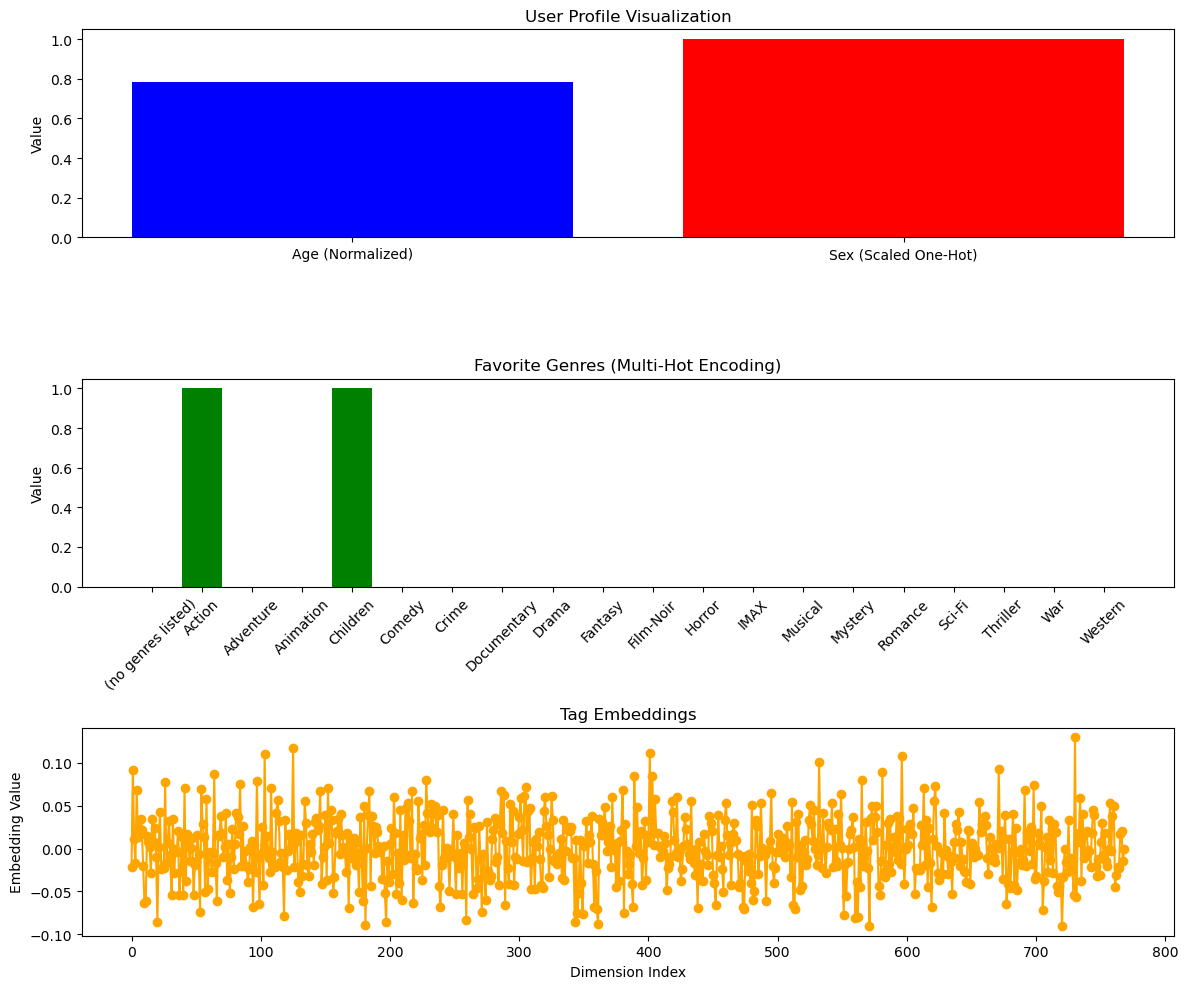

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_user_profile(user_profile, genre_vocab, tag_dim, user_id=None):
    """
    Visualize the components of a user profile embedding.

    Parameters:
    -----------
    user_profile : np.ndarray
        The user profile embedding to visualize.
    genre_vocab : list
        List of genres corresponding to the multi-hot encoded genres.
    tag_dim : int
        Dimension of the tag embeddings.
    user_id : int or None
        Optional ID of the user for labeling the plot.
    """
    # Extract components from the user profile
    numeric_feature = user_profile[0]  # Age normalization
    genre_features = user_profile[1:1 + len(genre_vocab)]  # Multi-hot genres
    tag_embeddings = user_profile[1 + len(genre_vocab):1 + len(genre_vocab) + tag_dim]  # Tag embeddings
    scaled_one_hot_features = user_profile[1 + len(genre_vocab) + tag_dim:]  # Scaled one-hot features (e.g., sex)

    # Create subplots to visualize each component
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    # Plot normalized numeric feature (e.g., age)
    axes[0].bar(['Age (Normalized)'], [numeric_feature], color='blue')
    axes[0].set_title(f"User Profile Visualization: User {user_id}" if user_id else "User Profile Visualization")
    axes[0].set_ylabel("Value")

    # Plot multi-hot encoded genres
    axes[1].bar(genre_vocab, genre_features, color='green')
    axes[1].set_title("Favorite Genres (Multi-Hot Encoding)")
    axes[1].set_ylabel("Value")
    axes[1].tick_params(axis='x', rotation=45)

    # Plot tag embeddings (compressed representation)
    axes[2].plot(range(len(tag_embeddings)), tag_embeddings, color='orange', marker='o', linestyle='-')
    axes[2].set_title("Tag Embeddings")
    axes[2].set_ylabel("Embedding Value")
    axes[2].set_xlabel("Dimension Index")

    # Add scaled one-hot features to the numeric feature subplot
    if scaled_one_hot_features.size > 0:
        axes[0].bar(
            ['Sex (Scaled One-Hot)'] * len(scaled_one_hot_features),
            scaled_one_hot_features,
            color='red'
        )

    plt.tight_layout()
    plt.show()

# Example Usage:
# Assume `user_profiles` is the matrix of all user profiles,
# `genre_vocab` is the list of genres, and `user_profiles.shape[1]` includes tag_dim and other features.
user_id = 0  # Index of the user to visualize
tag_dim = user_profiles.shape[1] - (1 + len(genre_vocab) + 1)  # Calculate tag_dim
visualize_user_profile(user_profiles[user_id], genre_vocab, tag_dim, user_id=user_id)

Read the existing movie profiles from a dataset (we created them in earlier notebooks):

In [8]:
print("Loading movie profiles from disk...")
movie_profiles = np.load(MOVIE_EMBEDDINGS_PATH)
print("Movie profiles loaded.")

Loading movie profiles from disk...
Movie profiles loaded.


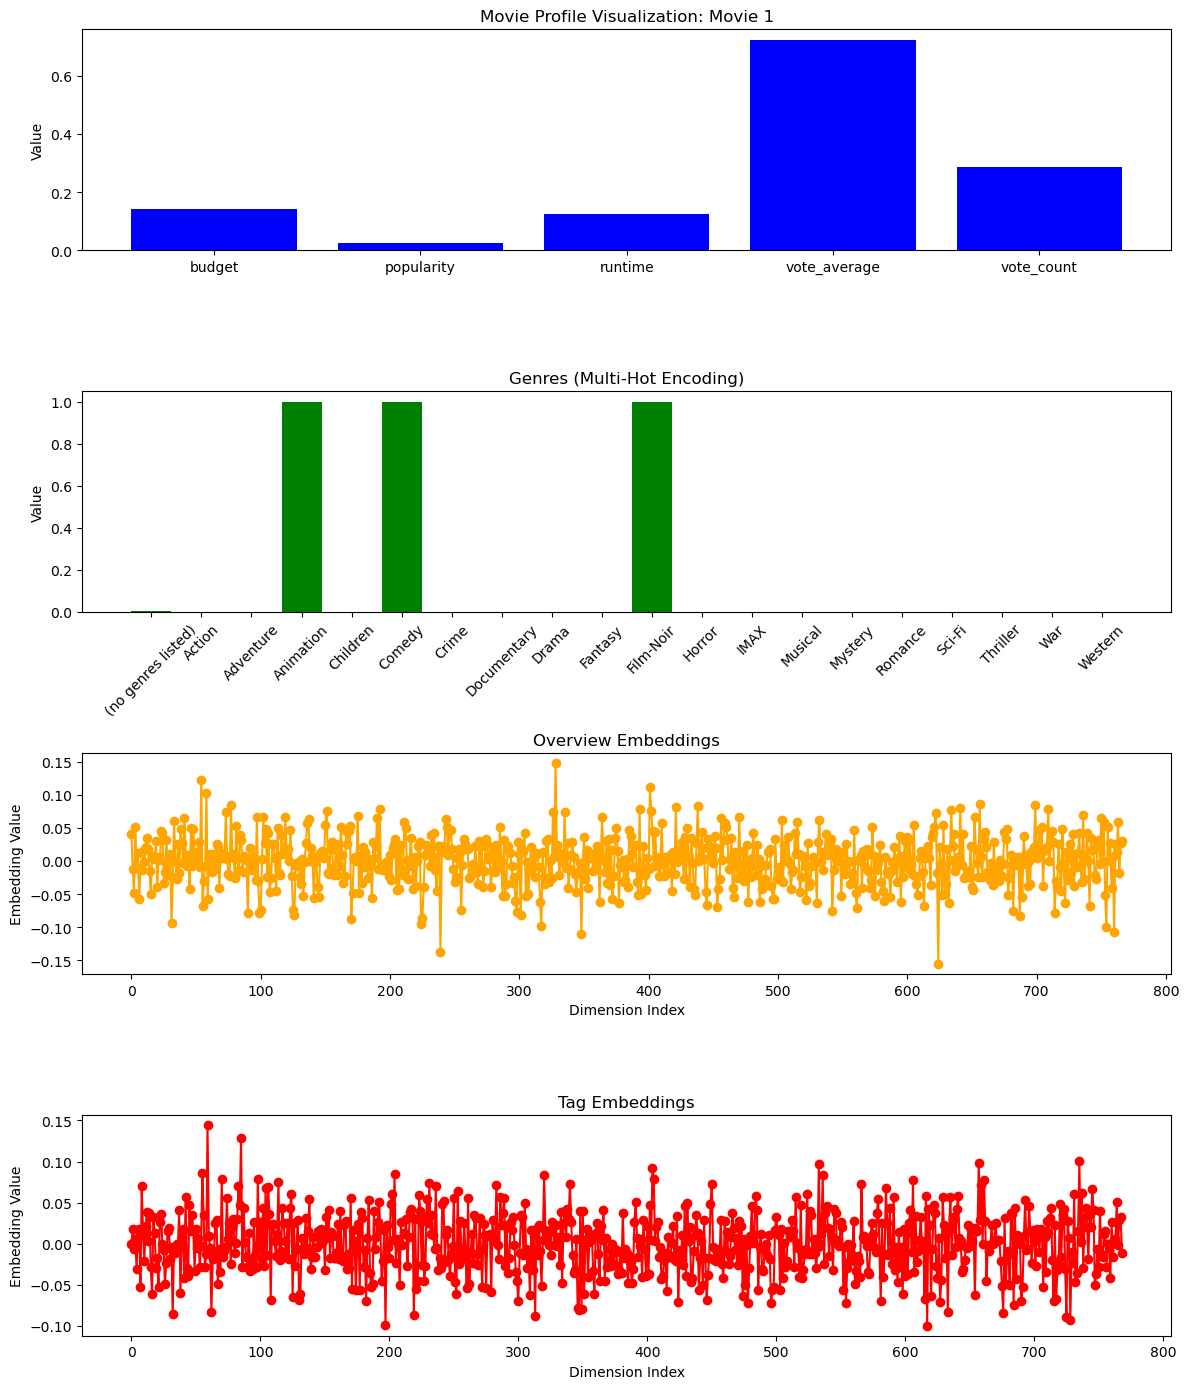

In [10]:
def visualize_movie_profile(movie_profile, genre_vocab, overview_dim, tag_dim, numeric_cols, movie_id=None):
    """
    Visualize the components of a movie profile embedding.

    Parameters:
    -----------
    movie_profile : np.ndarray
        The movie profile embedding to visualize.
    genre_vocab : list
        List of genres corresponding to the multi-hot encoded genres.
    overview_dim : int
        Dimension of the overview embeddings.
    tag_dim : int
        Dimension of the tag embeddings.
    numeric_cols : list
        Names of the numeric columns for the movie.
    movie_id : int or None
        Optional ID of the movie for labeling the plot.
    """
    # Extract components from the movie profile
    numeric_features = movie_profile[:len(numeric_cols)]  # Normalized numeric features
    overview_embeddings = movie_profile[len(numeric_cols):len(numeric_cols) + overview_dim]  # Overview embeddings
    genre_features = movie_profile[len(numeric_cols) + overview_dim:len(numeric_cols) + overview_dim + len(genre_vocab)]  # Multi-hot genres
    tag_embeddings = movie_profile[len(numeric_cols) + overview_dim + len(genre_vocab):]  # Tag embeddings

    # Create subplots to visualize each component
    fig, axes = plt.subplots(4, 1, figsize=(12, 14))

    # Plot normalized numeric features
    axes[0].bar(numeric_cols, numeric_features, color='blue')
    axes[0].set_title(f"Movie Profile Visualization: Movie {movie_id}" if movie_id else "Movie Profile Visualization")
    axes[0].set_ylabel("Value")

    # Plot multi-hot encoded genres
    axes[1].bar(genre_vocab, genre_features, color='green')
    axes[1].set_title("Genres (Multi-Hot Encoding)")
    axes[1].set_ylabel("Value")
    axes[1].tick_params(axis='x', rotation=45)

    # Plot overview embeddings (compressed representation)
    axes[2].plot(range(len(overview_embeddings)), overview_embeddings, color='orange', marker='o', linestyle='-')
    axes[2].set_title("Overview Embeddings")
    axes[2].set_ylabel("Embedding Value")
    axes[2].set_xlabel("Dimension Index")

    # Plot tag embeddings (compressed representation)
    axes[3].plot(range(len(tag_embeddings)), tag_embeddings, color='red', marker='o', linestyle='-')
    axes[3].set_title("Tag Embeddings")
    axes[3].set_ylabel("Embedding Value")
    axes[3].set_xlabel("Dimension Index")

    plt.tight_layout()
    plt.show()

# Example Usage:
# Assume `movie_profiles` is the matrix of all movie profiles,
# `genre_vocab` is the list of genres, and `numeric_cols` is the list of numeric columns.
movie_id = 1  # Index of the movie to visualize
overview_dim = movie_profiles.shape[1] - (5 + len(genre_vocab) + tag_dim)  # Calculate overview_dim
visualize_movie_profile(
    movie_profiles[movie_id], 
    genre_vocab, 
    overview_dim, 
    tag_dim=100,  # Replace with actual tag embedding dimension
    numeric_cols=['budget', 'popularity', 'runtime', 'vote_average', 'vote_count'], 
    movie_id=movie_id
)


In [15]:
from codebase.v13.recommendation_net import ConfigurableRecommendationNet

model_path = "saved_weights/rec-net/adv-10k-users-with-genres-alpha-0.7-fm-tuned-unscaled.pth"

# Reinitialize the model architecture
checkpoint = torch.load(model_path, weights_only=True)

# AdvancedContentRecommendationNet model
loaded_model = ConfigurableRecommendationNet(
    user_dim=checkpoint['user_dim'],
    movie_dim=checkpoint['movie_dim'],
    dense_hidden=checkpoint['dense_hidden'],
    fm_latent_dim=checkpoint['fm_latent_dim'],
    fm_hidden_dim=checkpoint['fm_hidden_dim'],
    transformer_d_model=checkpoint['transformer_d_model'],
    transformer_nhead=checkpoint['transformer_nhead'],
    transformer_feedforward=checkpoint['transformer_feedforward'],
    transformer_layers=checkpoint['transformer_layers'],
    multitask=checkpoint['multitask'],
    genres_vocab_size=checkpoint['num_genres'],
    use_fm=True,
    use_transformer=True
).to(device)

loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

/home/oliver/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ConfigurableRecommendationNet(
  (activation): ReLU()
  (user_dense): Linear(in_features=791, out_features=256, bias=True)
  (movie_dense): Linear(in_features=1561, out_features=256, bias=True)
  (fm_layer): FactorizationMachineLayer()
  (fm_proj): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (transformer_block): TransformerAttentionBlock(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm(

In [14]:
import torch
import numpy as np

def compute_genre_precision_at_k(
    user_profiles,
    movie_profiles,
    model,
    k=5,
    user_genre_start_idx=5,  # Assuming numeric features come first
    movie_genre_start_idx=1,  # Assuming numeric features come first
    genre_length=20     # Number of genre features
):
    """
    Compute genre alignment precision@k for all users.
    """
    device = next(model.parameters()).device

    # Convert profiles to tensors
    user_profiles_tensor = torch.tensor(user_profiles, dtype=torch.float32).to(device)
    movie_profiles_tensor = torch.tensor(movie_profiles, dtype=torch.float32).to(device)

    precision_per_user = []
    model.eval()
    
    with torch.no_grad():
        batch_size = 128
        for user_idx in range(len(user_profiles)):
            # Get user genre preferences
            user_genres = user_profiles[user_idx, user_genre_start_idx:user_genre_start_idx+genre_length]
            user_favorite_genres = set(np.where(user_genres > 0)[0])
            
            if not user_favorite_genres:
                continue

            # Prepare user profile
            user_profile = user_profiles_tensor[user_idx:user_idx+1]
            
            # Compute predictions in batches
            all_scores = []
            for i in range(0, len(movie_profiles), batch_size):
                batch_movies = movie_profiles_tensor[i:i+batch_size]
                batch_user = user_profile.repeat(len(batch_movies), 1)
                scores, _ = model(batch_user, batch_movies)
                all_scores.append(scores.squeeze())
            
            # Combine all scores
            scores = torch.cat(all_scores).cpu().numpy()
            
            # Get top-k movie indices
            top_k_indices = np.argsort(scores)[-k:][::-1]
            
            # Calculate genre alignment
            genre_hits = 0
            for movie_idx in top_k_indices:
                movie_genres = set(np.where(
                    movie_profiles[movie_idx, movie_genre_start_idx:movie_genre_start_idx+genre_length] > 0)[0]
                )
                if movie_genres.intersection(user_favorite_genres):
                    genre_hits += 1
            
            precision_k = genre_hits / k
            precision_per_user.append(precision_k)

    return np.mean(precision_per_user) if precision_per_user else 0.0


In [19]:
genre_precision = compute_genre_precision_at_k(
    user_profiles=user_profiles,
    movie_profiles=movie_profiles,
    model=loaded_model,
    k=5,
    user_genre_start_idx=1,  # Adjust based on your profile structure
    movie_genre_start_idx=5 + 768,
    genre_length=20     # Adjust based on number of genres
)
print(f"Genre Precision@5: {genre_precision:.4f}")

Genre Precision@5: 0.2460
